## Solar challenge - Togo

## Summary Statistics & Missing-Value Report

We begin the EDA by checking the summary statistics of all numeric columns and identifying columns with missing values. Columns with more than 5% null values are flagged.


In [14]:
import pandas as pd

# Load the dataset
df = pd.read_csv('../data/togo-dapaong_qc.csv')

# Display the first few rows of the dataset
df.head()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-25 00:01,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
1,2021-10-25 00:02,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN
2,2021-10-25 00:03,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN
3,2021-10-25 00:04,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN
4,2021-10-25 00:05,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN


In [15]:
# Summary statistics
df.describe()

,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,230.555040,151.258469,116.444352,226.144375,219.568588,27.751788,55.013160,2.368093,3.229490,0.557740,161.741845,10.559568,975.915242,0.000535,0.001382,32.444403,33.543330,NaN
std,322.532347,250.956962,156.520714,317.346938,307.932510,4.758023,28.778732,1.462668,1.882565,0.268923,91.877217,5.915490,2.153977,0.023116,0.026350,10.998334,12.769277,NaN
min,-12.700000,0.000000,0.000000,0.000000,0.000000,14.900000,3.300000,0.000000,0.000000,0.000000,0.000000,0.000000,968.000000,0.000000,0.000000,13.100000,13.100000,NaN
25%,-2.200000,0.000000,0.000000,0.000000,0.000000,24.200000,26.500000,1.400000,1.900000,0.400000,74.800000,6.900000,975.000000,0.000000,0.000000,23.900000,23.600000,NaN
50%,2.100000,0.000000,2.500000,4.400000,4.300000,27.200000,59.300000,2.200000,2.900000,0.500000,199.100000,10.800000,976.000000,0.000000,0.000000,28.400000,28.400000,NaN
75%,442.400000,246.400000,215.700000,422.525000,411.000000,31.100000,80.800000,3.200000,4.400000,0.700000,233.500000,14.100000,977.000000,0.000000,0.000000,40.600000,43.000000,NaN
max,1424.000000,1004.500000,805.700000,1380.000000,1367.000000,41.400000,99.800000,16.100000,23.100000,4.700000,360.000000,86.900000,983.000000,1.000000,2.300000,70.400000,94.600000,NaN


In [16]:
# Missing value report
missing_report = df.isna().sum()
print("Missing Values Per Column:\n", missing_report)

# Flag columns with >5% missing data
threshold = 0.05 * len(df)
high_missing_cols = missing_report[missing_report > threshold]
print("\nColumns with >5% missing values:\n", high_missing_cols)


Missing Values Per Column:
 Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64

Columns with >5% missing values:
 Comments    525600
dtype: int64


## Outlier Detection & Basic Cleaning

We check for outliers using Z-scores in sensor and irradiance readings, and handle missing values in key columns using median imputation.


In [17]:
from scipy.stats import zscore
import numpy as np

key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
df_clean = df.copy()

cols = ['ModA', 'ModB', 'WS', 'WSgust']
z_scores_df = df[cols].apply(zscore)
for col in cols:
    outlier_flags = z_scores_df[col].abs() > 3
    outlier_rows = df[outlier_flags]
    print(f"col {col} has {len(outlier_rows)} outliers and {round(len(outlier_rows) / len(df) * 100, 2)}% of the data")

# Compute Z-scores and flag outliers
z_scores = df_clean[key_columns].apply(zscore)
outliers = (np.abs(z_scores) > 3).any(axis=1)

print(f"Total outliers flagged: {outliers.sum()}")

# Impute missing values with median
df_clean[key_columns] = df_clean[key_columns].fillna(df_clean[key_columns].median())

# Export cleaned data
df_clean.to_csv("data/togo_clean.csv", index=False)
print("✅ Cleaned data exported to 'data/togo_clean.csv'")

col ModA has 137 outliers and 0.03% of the data
col ModB has 206 outliers and 0.04% of the data
col WS has 3510 outliers and 0.67% of the data
col WSgust has 3915 outliers and 0.74% of the data
Total outliers flagged: 9251
✅ Cleaned data exported to 'data/togo_clean.csv'


## Time Series Analysis

We analyze GHI, DNI, DHI, and ambient temperature (Tamb) over time using line plots to observe patterns by month, day, or unusual spikes.


In [18]:
import matplotlib.pyplot as plt

# Convert the 'Timestamp' column to datetime
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])

# Check the data types to confirm the change
print(df_clean.dtypes)


Timestamp        datetime64[ns]
GHI                     float64
DNI                     float64
DHI                     float64
ModA                    float64
ModB                    float64
Tamb                    float64
RH                      float64
WS                      float64
WSgust                  float64
WSstdev                 float64
WD                      float64
WDstdev                 float64
BP                        int64
Cleaning                  int64
Precipitation           float64
TModA                   float64
TModB                   float64
Comments                float64
dtype: object


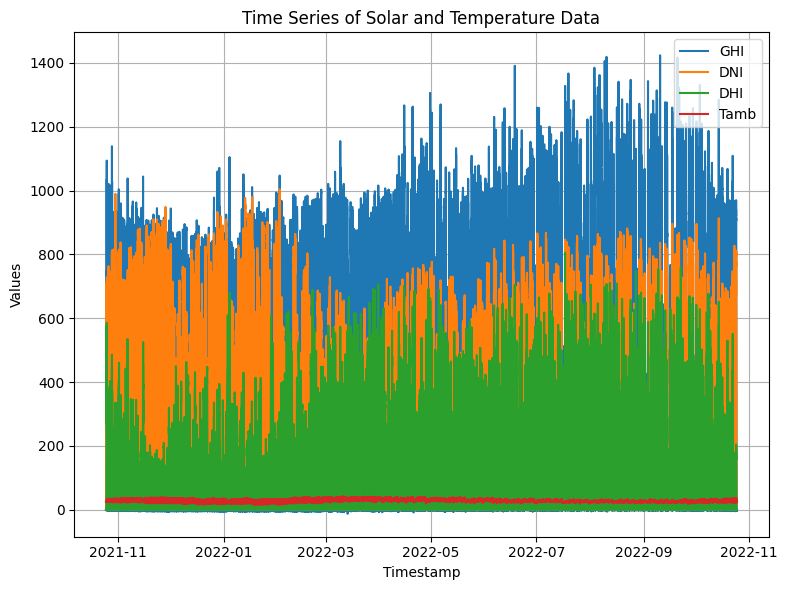

In [19]:
plt.figure(figsize=(8, 6))
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    plt.plot(df_clean['Timestamp'], df_clean[col], label=col)
plt.legend(loc='upper right')
plt.title("Time Series of Solar and Temperature Data")
plt.xlabel("Timestamp")
plt.ylabel("Values")
plt.grid(True)
plt.tight_layout()
plt.show()


## Cleaning Impact on ModA and ModB

We analyze the effect of cleaning actions on sensor readings by grouping by the cleaning flag.


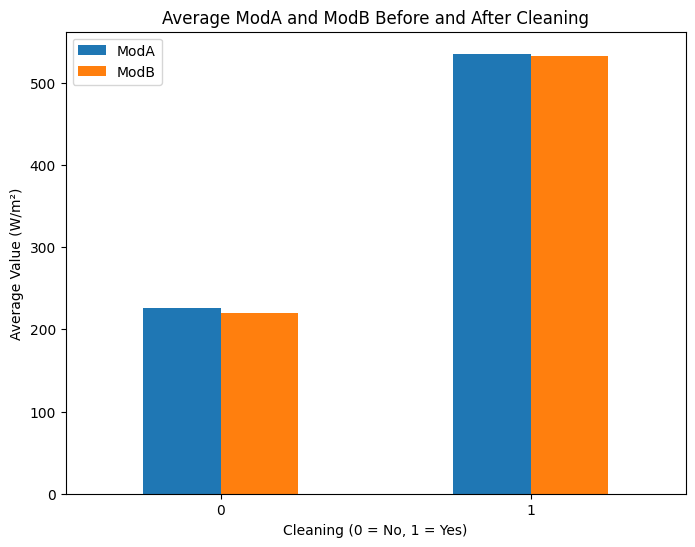

In [20]:
cleaning_impact = df.groupby('Cleaning')[['ModA', 'ModB']].mean()
cleaning_impact.plot(kind='bar', figsize=(8, 6))
plt.title('Average ModA and ModB Before and After Cleaning')
plt.xlabel('Cleaning (0 = No, 1 = Yes)')
plt.ylabel('Average Value (W/m²)')
plt.xticks(rotation=0)
plt.show()

## Correlation and Relationship Analysis

Visualize relationships between variables using a heatmap and scatter plots.


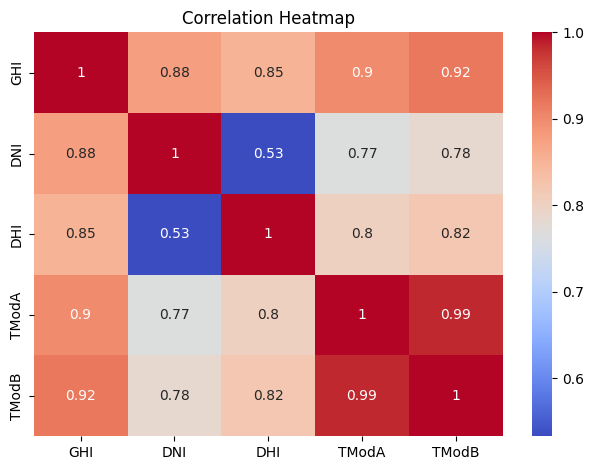

In [21]:
import seaborn as sns

# Heatmap
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
sns.heatmap(df_clean[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


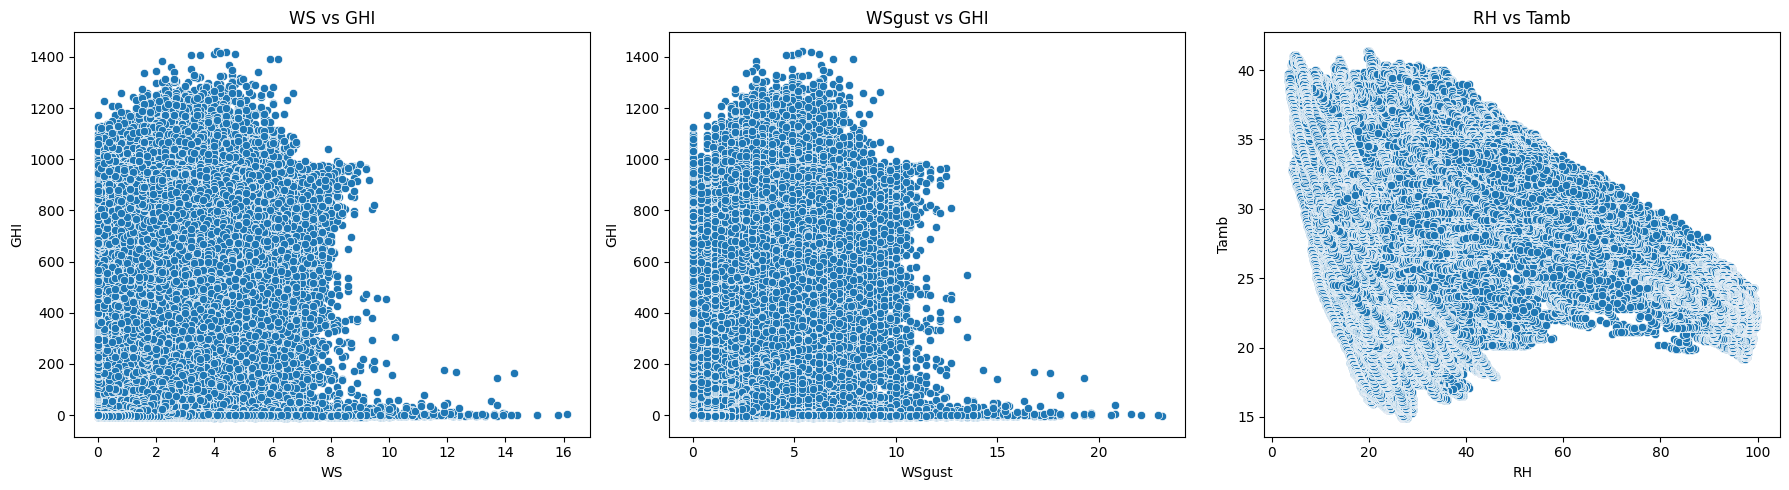

In [22]:
# Scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.scatterplot(x='WS', y='GHI', data=df_clean, ax=axes[0])
sns.scatterplot(x='WSgust', y='GHI', data=df_clean, ax=axes[1])
sns.scatterplot(x='RH', y='Tamb', data=df_clean, ax=axes[2])
axes[0].set_title("WS vs GHI")
axes[1].set_title("WSgust vs GHI")
axes[2].set_title("RH vs Tamb")
plt.tight_layout()
plt.show()

## Wind and Distribution Analysis

We visualize wind direction and speed using a wind rose and inspect the distribution of GHI and WS using histograms.


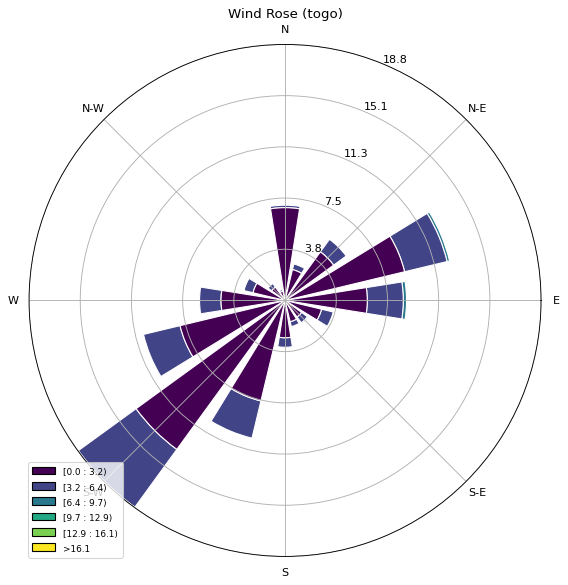

In [23]:
#Wind Rose:
from windrose import WindroseAxes
ax = WindroseAxes.from_ax()
ax.bar(df['WD'], df['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Wind Rose (togo)')
plt.show()


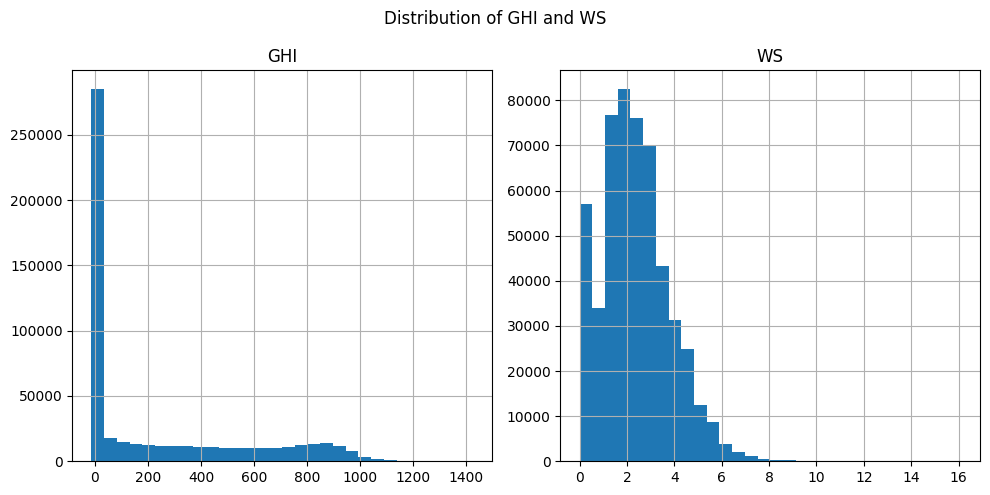

In [24]:
# Histograms
df_clean[['GHI', 'WS']].hist(bins=30, figsize=(10, 5))
plt.suptitle("Distribution of GHI and WS")
plt.tight_layout()
plt.show()


## Temperature and Relative Humidity Analysis

We examine the relationship between temperature and humidity to understand their mutual influence on solar radiation.


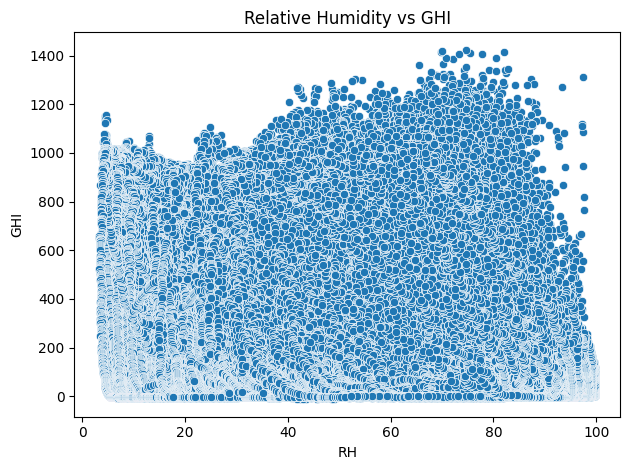

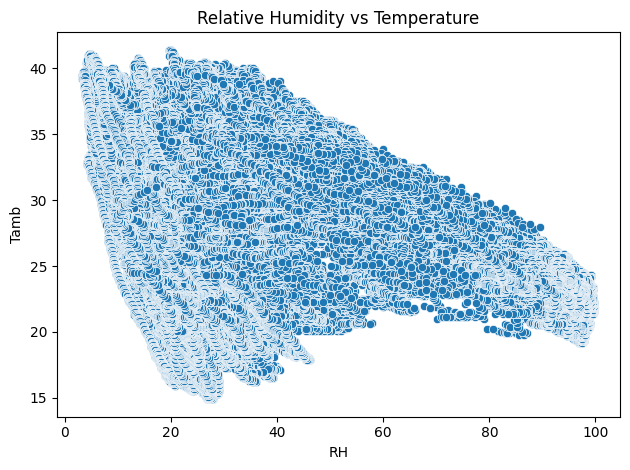

In [25]:
sns.scatterplot(x='RH', y='GHI', data=df_clean)
plt.title("Relative Humidity vs GHI")
plt.tight_layout()
plt.show()

sns.scatterplot(x='RH', y='Tamb', data=df_clean)
plt.title("Relative Humidity vs Temperature")
plt.tight_layout()
plt.show()



## Bubble Chart: GHI vs. Tamb with Bubble Size as RH

We create a bubble chart to explore how RH or BP modulates the relationship between GHI and ambient temperature.


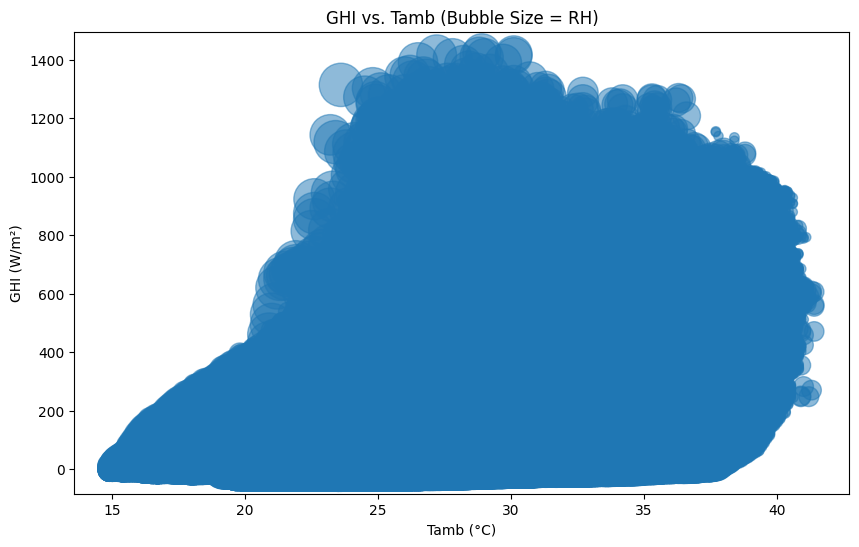

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Tamb'], df['GHI'], s=df['RH']*10, alpha=0.5)
plt.title('GHI vs. Tamb (Bubble Size = RH)')
plt.xlabel('Tamb (°C)')
plt.ylabel('GHI (W/m²)')
plt.show()
